## GEORGIOS KOUTROUMPIS, AEM 9668
### ECE AUTh, 2022
### Computational Intelligence
#### Project 3, MLP

In [ ]:
%pip install -q -U keras-tuner

In [ ]:
# Imports
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from time import time
from tensorflow.keras import backend as K
import keras_tuner as kt

In [ ]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Scale data value to [0,1]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

n_train = X_train.shape[0]

# Convert classes to one-hot encoding (categorical)

num_of_classes = 10

Y_train = to_categorical(Y_train, num_of_classes)
Y_test = to_categorical(Y_test, num_of_classes)

In [ ]:
# Functions that calculate the recall, precision and F1-Score metrics

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# A model builder function to be used with Keras Tuner
def model_builder(hp):

  # Start creating model
  model = Sequential()

  # Add a layer to flatten data to 1-D
  model.add(Flatten(input_shape=(28, 28)))

  # Create the hyper-parameter options for units, l2 factor and learning rate
  hp_units_layer_1 = hp.Choice('units1', values=[64,128])
  hp_units_layer_2 = hp.Choice('units2', values=[256,512])

  hp_reg_factor = hp.Choice('l2', values=[1e-1, 1e-3, 1e-6])
  
  hp_lr = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

  # Initialize regularizer
  reg_1 = regularizers.L2(l2=hp_reg_factor)
  reg_2 = regularizers.L2(l2=hp_reg_factor)
  reg_3 = regularizers.L2(l2=hp_reg_factor)

  # Initialize optimizer
  optimizer = RMSprop(learning_rate=hp_lr)

  # Add the specified layers
  model.add(Dense(units=hp_units_layer_1, \
                  activation="relu", \
                  kernel_regularizer = reg_1, \
                  kernel_initializer=initializers.HeNormal()))
  
  model.add(Dense(units=hp_units_layer_2, activation="relu", \
                  kernel_regularizer = reg_2, \
                  kernel_initializer=initializers.HeNormal()))

  model.add(Dense(num_of_classes, \
                kernel_initializer=initializers.HeNormal(),\
                kernel_regularizer = reg_3, \
                activation="softmax"))
  
  model.compile(optimizer=optimizer, loss='categorical_crossentropy',\
                metrics=['accuracy', f1_m])
  return model

In [ ]:
# Use Hyperband to find the best model

epochs = 1000

tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_f1_m", direction="max"),
                     max_epochs=epochs,
                     factor=3,
                     overwrite=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

# Search for the best model
tuner.search(X_train, Y_train, epochs=epochs, validation_split=0.2, callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, in the second layer is {best_hps.get('units2')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, and alpha for regularization is {best_hps.get('l2')}.
""")


Trial 33 Complete [00h 00m 15s]
val_f1_m: 0.17934100329875946

Best val_f1_m So Far: 0.968400776386261
Total elapsed time: 00h 08m 43s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128, in the second layer is 512, the optimal learning rate for the optimizer
is 0.001, and alpha for regularization is 1e-06.



In [ ]:
# Train a model using the best hyper-parameters

hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(X_train, Y_train, epochs=epochs, validation_split=0.2)

Epoch 1/1000
1500/1500 [==============================] - 9s 5ms/step - loss: 0.2337 - accuracy: 0.9297 - f1_m: 0.9276 - val_loss: 0.1356 - val_accuracy: 0.9621 - val_f1_m: 0.9621
Epoch 2/1000
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1093 - accuracy: 0.9687 - f1_m: 0.9691 - val_loss: 0.1191 - val_accuracy: 0.9670 - val_f1_m: 0.9676
Epoch 3/1000
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0812 - accuracy: 0.9773 - f1_m: 0.9773 - val_loss: 0.1187 - val_accuracy: 0.9703 - val_f1_m: 0.9706
Epoch 4/1000
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0660 - accuracy: 0.9820 - f1_m: 0.9823 - val_loss: 0.1118 - val_accuracy: 0.9746 - val_f1_m: 0.9748
Epoch 5/1000
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0546 - accuracy: 0.9853 - f1_m: 0.9853 - val_loss: 0.1213 - val_accuracy: 0.9758 - val_f1_m: 0.9759
Epoch 6/1000
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0484 - accuracy: 0.9

In [ ]:
%pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


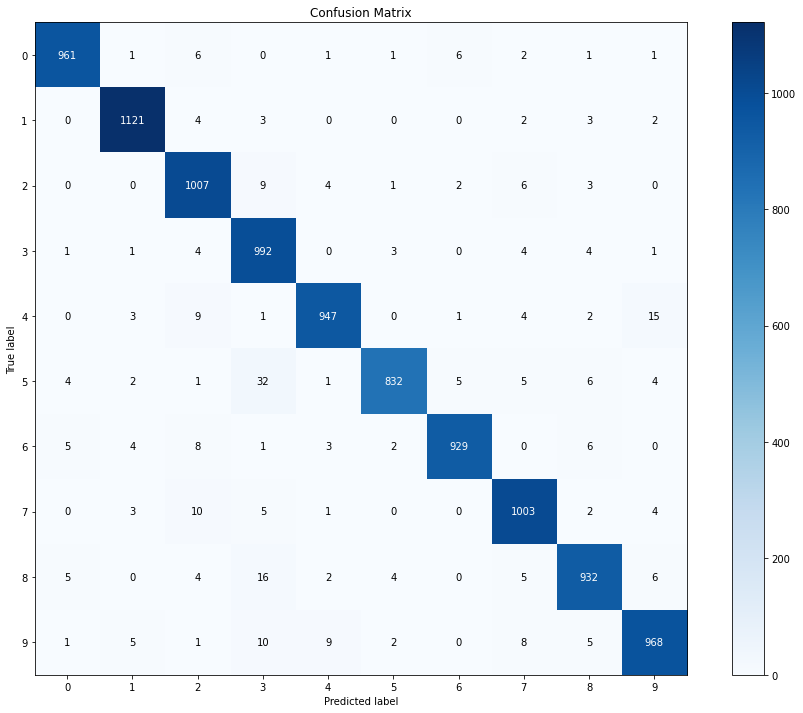

In [ ]:
from scikitplot.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Predict the test values
y_prediction = hypermodel.predict(X_test)
y_prediction = np.argmax(y_prediction,axis=1)

y_test = tensorflow.argmax(Y_test, axis = 1)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_test, y_prediction, ax=ax)


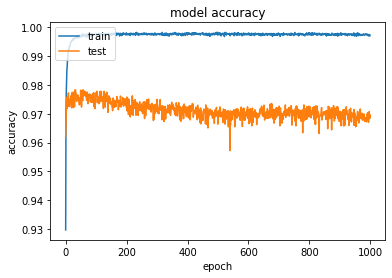

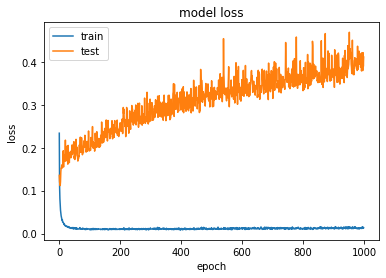

In [ ]:
# Plot the accuracy and loss graphs of the model's training
def plot_accuracy_loss(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_accuracy_loss(history)